# Lab DL 9: GAN untuk Image Generation
Nama : Hendardi Yoga Pratama

NIM  :2000018302

# **1. Pendahuluan**

---
## GAN Networks

In a GAN, we build two different neural networks.

Our first network is a traditional classification network, called the **DISCRIMINATOR**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set).

Our other network, called the **GENERATOR**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

<center>
<img src="https://i.ibb.co/4RyZ2Vr/gan-en.png" width=80% />
</center>
<br>

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:

$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where
* $z \sim p(z)$ are the random noise samples,
* $G(z)$ are the generated images using the neural network generator $G$, and
* $D$ is the output of the discriminator, specifying the probability of an input being real.

<br>

In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

# **2. Mounting Google Drive**

In [2]:
from google.colab import drive

# mounting dataset dari gdrive
drive.mount('/content/gdrive', force_remount=True)

# lokasi dataset - ubah sesuai dengan lokasi anda mengupload folder datanya
# folder ini juga digunakan untuk menyimpan model yang sudah dilatih
root_path = 'gdrive/My Drive/Colab Notebooks/Deep Learning Labs/LabDL09 Data/'

# opsional - tampilkan info lokasi dataset
print("Path root:", root_path)

Mounted at /content/gdrive
Path root: gdrive/My Drive/Colab Notebooks/Deep Learning Labs/LabDL09 Data/


# **3. Download Dataset**
Download dataset dan simpan di gdrive yang sudah disediakan.
Kita menggunakan MNIST digit dataset

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical

import os, time, glob, imageio, PIL, pathlib
from IPython.display import Image

os.chdir(root_path)
if not os.path.exists('imgs'):
    os.mkdir('imgs')

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
#(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = np.concatenate([X_train, X_test])

4422102/4422102 [==============================] - 1s 0us/step


Normalisasi data latih

In [4]:
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, :, :, None]

# **4. Fungsi untuk Mengolah Dataset**
Fungsi untuk mengolah dataset

In [5]:
def combine_images(images):
    num = images.shape[0]
    width = int(np.sqrt(num))
    height = int(np.ceil(float(num)/width))
    shape = images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=images.dtype)
    for index, img in enumerate(images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    image = image*127.5+127.5

    return image

def generate_images(generator, batch_size, sampling='normal'):

    z_size = generator.layers[0].input_shape[1]
    if sampling == 'normal':
        noise = tf.random.normal(shape=(batch_size, z_size))
    else:
        noise = tf.random.uniform(shape=(batch_size, z_size), minval=-1, maxval=1)

    generated_images = generator.predict(noise, verbose=1)

    image = combine_images(generated_images)

    filename = "generated_image.png"
    PIL.Image.fromarray(image.astype(np.uint8)).save(filename)

    return image

def generate_best_images(generator, discriminator, batch_size, sampling='normal', tries=20):

    z_size = generator.layers[0].input_shape[1]
    if sampling == 'normal':
        noise = tf.random.normal(shape=(batch_size*tries, z_size))
    else:
        noise = tf.random.uniform(shape=(batch_size, z_size), minval=-1, maxval=1)


    generated_images = generator.predict(noise, verbose=0)
    d_pret = discriminator.predict(generated_images, verbose=0)

    index = np.arange(0, batch_size*tries)
    index.resize((batch_size*tries, 1))

    pre_with_index = list(np.append(d_pret, index, axis=1))
    pre_with_index.sort(key=lambda x: x[0], reverse=True)

    nice_images = np.zeros((batch_size,) + generated_images.shape[1:3], dtype=np.float32)
    nice_images = nice_images[:, :, :, None]

    for i in range(batch_size):
        idx = int(pre_with_index[i][1])
        nice_images[i, :, :, 0] = generated_images[idx, :, :, 0]

    image = combine_images(nice_images)

    filename = "generated_image_best.png"
    PIL.Image.fromarray(image.astype(np.uint8)).save(filename)

    return image

def show_gif(base_dir, anim_file):

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob(base_dir+'/image*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            for i in range(3):
                writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

    print('GIF saved as', anim_file)

    with open(anim_file,'rb') as f:
        display(Image(data=f.read(), format='png'))

# **5. Membangun Model GAN**

---
# [Part 1] GAN Training
Inside the training loop, there are basically three steps to train GANs.


<center>
<img src="https://i.ibb.co/Y388bJb/gan-steps-en.png" width=80% />
</center>
<br>

First, in each iteration, we use the current Generator to generate new batch of fake data from random latent space. Then the second is we use the generated batch along with a real batch of data to train one step of the Discriminator Model (one time forward and backward pass). The objective here is to minimize the binary crossentropy loss between the fake and real class.

The last is to train the Generator Model by feeding in a batch of random latent space to generate a batch of fake data (forward pass). The batch of fake data then feed into the trained Discriminator from previous step (forward pass). The objective here is to maximize the wrongly classified data, which we can turn into minimizing correctly classified data. The loss is then used to update **ONLY** the Generator Model's weights (backward pass)


---
##1 - Define Models

As mentioned before, there are two networks inside GAN, namely Generator and Discriminator.

As a side note, The rectified linear activation unit, or ReLU for short, is a simple calculation that returns the value provided as input directly, or the value 0.0 if the input is 0.0 or less.

It has become a best practice when developing deep convolutional neural networks generally, which it's also implemented in this exmaple.

However, best practice for GANs is to use a variation of the ReLU that allows some values less than zero and learns where the cut-off should be in each node. This is called the leaky rectified linear activation unit, or LeakyReLU for short. You can try and change the activation function yourself.


### Generator Model

The generator model must generate an output image given as input at a random point from the latent space.

The recommended approach for achieving this is to use a transpose convolutional layer with a strided convolution. This is a special type of layer that performs the convolution operation in reverse.

Intuitively, this means that setting a stride of $2×2$ will have the opposite effect, upsampling the input instead of downsampling it in the case of a normal convolutional layer.


<center>
<img src="https://i.ibb.co/s2gX3jR/generator1.png" width=70% />
</center>


By stacking a transpose convolutional layer with strided convolutions, the generator model is able to scale a given input to the desired output dimensions. It is also recommended in using Batch Normalization to standardizes the activations from a prior layer to have a zero mean and unit variance. This has the effect of stabilizing the training process.

## 5.1. Generator Model

In [6]:
def generator_model(latent_dim = 128):
    model = Sequential([
        Dense(1024, input_dim=latent_dim, activation='relu'),
        BatchNormalization(),
        Dense(7 * 7 * 128, activation='relu'),
        Reshape((7, 7, 128)),
        Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2DTranspose(1, (5, 5), strides=(2,2), padding='same', activation='tanh'),
    ])
    return model

generator_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              132096    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 6272)              6428800   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

### Discriminator Model

The discriminator model is a standard convolutional neural network model that takes an image as input and must output a binary classification as to whether it is real or fake.


<center>
<img src="https://i.ibb.co/nnxBg8S/discriminator1.png" width=70% />
</center>


It is standard practice with deep convolutional networks to use pooling layers to downsample the input and feature maps with the depth of the network, like implemented below.

However, turns out this is not recommended for the DCGAN, and instead, they recommend downsampling using strided convolutions. You can try and change the `maxpool` below using strided convolution yourself.

## 5.2. Discriminator Model

In [7]:
def discriminator_model():
    model = Sequential([
        Conv2D(32, (5, 5), input_shape=(28, 28, 1), padding='same'),
        LeakyReLU(alpha=0.01),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (5, 5)),
        LeakyReLU(alpha=0.01),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(4 * 4 * 64, activation='tanh'),
        Dense(1, activation='sigmoid')
    ])
    return model

discriminator_model().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 10, 10, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

## 5.3. Gabungkan Kedua Model

In [8]:
def combine_model(g, d):
    model = Sequential()
    model.add(g)
    model.add(d)
    return model

# **6. Pelatihan Model GAN**

---
## 2 - Training Functions

The latent space defines the shape and distribution of the input to the generator model used to generate new images.

The DCGAN recommends sampling from a uniform distribution, meaning that the shape of the latent space is a hypercube.

The more recent best practice is to sample from a standard Gaussian distribution, meaning that the shape of the latent space is a hypersphere, with a mean of zero and a standard deviation of one.

Tom White's [Sampling Generative Networks](https://arxiv.org/abs/1609.04468), ref code https://github.com/dribnet/plat has more details

---
The discriminator model is trained using stochastic gradient descent with mini-batches.

The best practice is to update the discriminator with separate batches of real and fake images rather than combining real and fake images into a single batch.

This can be achieved by updating the model weights for the discriminator model with two separate calls to the `train_on_batch()` function. You can try and change this yourself.

---
It is common to use the class label 1 to represent real images and class label 0 to represent fake images when training the discriminator model.

These are called hard labels, as the label values are precise or crisp.

It is a good practice to use soft labels as mentioned by Salimans et. al. 2016. Such values are slightly more or less than 1.0 or slightly more than 0.0 for real and fake images respectively, where the variation for each image is random.

This is often referred to as label noise or smoothing and can have a regularizing effect when training the model.

## 6.1. Fungsi Pelatihan

In [9]:
def train_gan(X_train, Y_train,
              batch_size, epochs,
              models, sampling='normal',
              save_every=500, print_every=100):

    def sampling_fn(shape):
        if sampling == 'normal':
            return tf.random.normal(shape)
        else:
            return tf.random.uniform(shape, minval=-1, maxval=1)


    g, d, d_on_g = models


    print('Start training using random', sampling, 'distribution')
    print('Number of batches', int(X_train.shape[0]/batch_size))

    z_size = g.layers[0].input_shape[1]
    seed_saved = sampling_fn(shape=(16, z_size))
    img_count = 0

    start = time.time()

    for epoch in range(epochs):
        print("\n-------------------------------\nEpoch is", epoch)

        for index in range(int(X_train.shape[0]/batch_size)):

            noise = sampling_fn(shape=(batch_size, z_size))

            generated_images = g.predict(noise, verbose=0)

            image_batch = X_train[index*batch_size:(index+1)*batch_size]

            if index % save_every == 0:
                for_save = g.predict(seed_saved)
                image = combine_images(for_save)

                # simpan di folder gdrive imgs
                plt.imshow(image, cmap=plt.get_cmap('gray'))
                filename = 'imgs/image_'+'{:03}'.format(img_count)+'.png'
                plt.axis('off')
                plt.savefig(filename)
                plt.show()
                img_count += 1

            X = np.concatenate((image_batch, generated_images))
            y = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
            y += 0.05 * tf.random.uniform(tf.shape(y))

            d_loss = d.train_on_batch(X, y)

            noise = sampling_fn(shape=(batch_size, z_size))

            d.trainable = False
            y = tf.ones((batch_size, 1))
            g_loss = d_on_g.train_on_batch(noise, y)

            if index % print_every == 0:
                print("batch %d, g_loss : %f, d_loss : %f" % (index, g_loss, d_loss))

            d.trainable = True

    end = time.time()

    print('Training ended in', (end-start)/60, 'minutes')
    models = [g, d, d_on_g]

    return models

In [10]:
g_model = generator_model()
d_model = discriminator_model()

In [11]:
d_optim = Adam(learning_rate=0.0003, beta_1=0.5)
g_optim = Adam(learning_rate=0.0003, beta_1=0.5)

d_model.trainable = False
d_on_g = combine_model(g_model, d_model)
d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)

d_model.trainable = True
d_model.compile(loss='binary_crossentropy', optimizer=d_optim)

models = [g_model, d_model, d_on_g]

## 6.2. Pelatihan GAN

Start training using random normal distribution
Number of batches 311

-------------------------------
Epoch is 0
1/1 [==============================] - 0s 71ms/step


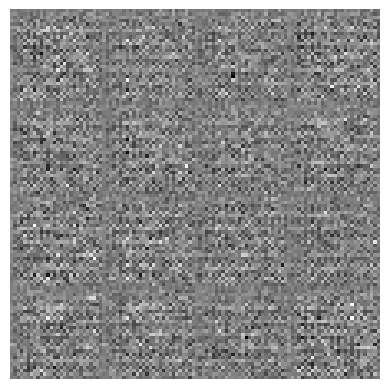

batch 0, g_loss : 0.118810, d_loss : 0.665086
batch 100, g_loss : 17.211197, d_loss : -0.447437
batch 200, g_loss : 2.855635, d_loss : 0.247195
batch 300, g_loss : 1.602037, d_loss : 0.455729

-------------------------------
Epoch is 1
1/1 [==============================] - 0s 18ms/step


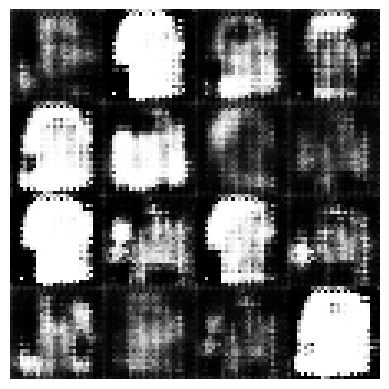

batch 0, g_loss : 1.621885, d_loss : 0.464357
batch 100, g_loss : 1.227381, d_loss : 0.551889
batch 200, g_loss : 0.667752, d_loss : 0.583871
batch 300, g_loss : 0.720769, d_loss : 0.597205

-------------------------------
Epoch is 2
1/1 [==============================] - 0s 20ms/step


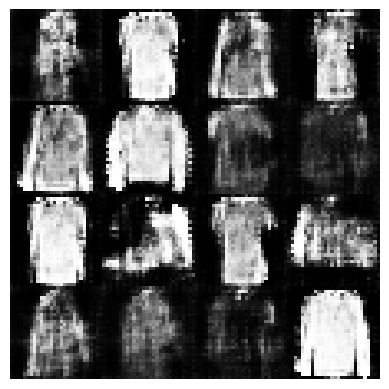

batch 0, g_loss : 0.971896, d_loss : 0.593737
batch 100, g_loss : 0.398989, d_loss : 0.720534
batch 200, g_loss : 0.810434, d_loss : 0.595665
batch 300, g_loss : 0.383986, d_loss : 0.675367

-------------------------------
Epoch is 3
1/1 [==============================] - 0s 19ms/step


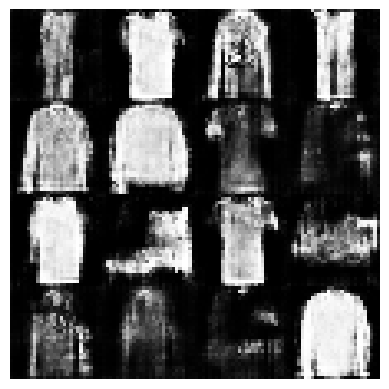

batch 0, g_loss : 0.514086, d_loss : 0.634765
batch 100, g_loss : 0.725898, d_loss : 0.620882
batch 200, g_loss : 0.792524, d_loss : 0.651328
batch 300, g_loss : 0.710326, d_loss : 0.618503

-------------------------------
Epoch is 4
1/1 [==============================] - 0s 27ms/step


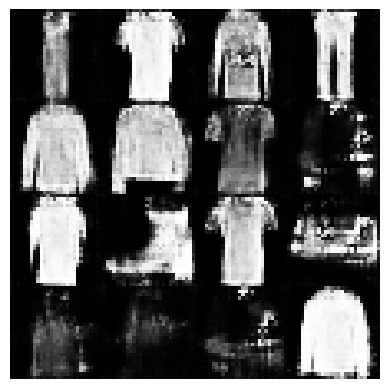

batch 0, g_loss : 0.537366, d_loss : 0.665786
batch 100, g_loss : 0.587074, d_loss : 0.662280
batch 200, g_loss : 0.407635, d_loss : 0.656540
batch 300, g_loss : 0.616432, d_loss : 0.640154

-------------------------------
Epoch is 5
1/1 [==============================] - 0s 22ms/step


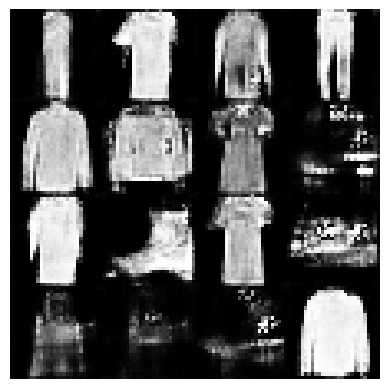

batch 0, g_loss : 0.656428, d_loss : 0.643821
batch 100, g_loss : 0.815466, d_loss : 0.650344
batch 200, g_loss : 0.699600, d_loss : 0.608730
batch 300, g_loss : 0.625847, d_loss : 0.648481

-------------------------------
Epoch is 6
1/1 [==============================] - 0s 18ms/step


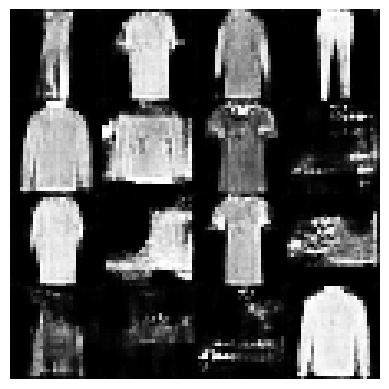

batch 0, g_loss : 0.532442, d_loss : 0.648133
batch 100, g_loss : 0.606049, d_loss : 0.646626
batch 200, g_loss : 0.734529, d_loss : 0.643977
batch 300, g_loss : 0.572385, d_loss : 0.636689

-------------------------------
Epoch is 7
1/1 [==============================] - 0s 36ms/step


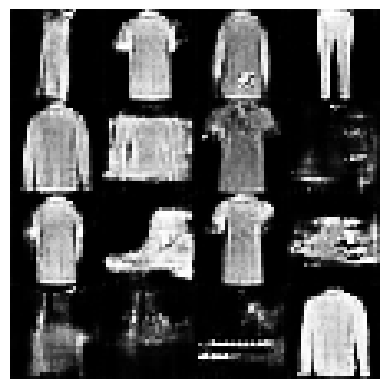

batch 0, g_loss : 0.282545, d_loss : 0.731376
batch 100, g_loss : 0.504836, d_loss : 0.672238
batch 200, g_loss : 0.641406, d_loss : 0.645948
batch 300, g_loss : 0.596475, d_loss : 0.649358

-------------------------------
Epoch is 8
1/1 [==============================] - 0s 21ms/step


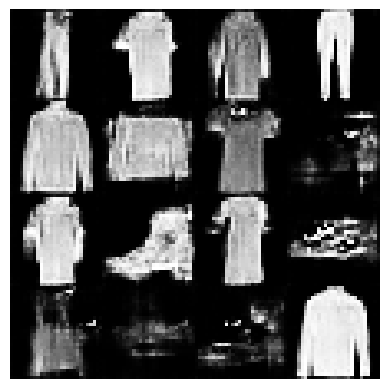

batch 0, g_loss : 0.950121, d_loss : 0.652892
batch 100, g_loss : 0.637169, d_loss : 0.663292
batch 200, g_loss : 0.552454, d_loss : 0.670851
batch 300, g_loss : 0.581949, d_loss : 0.657174

-------------------------------
Epoch is 9
1/1 [==============================] - 0s 20ms/step


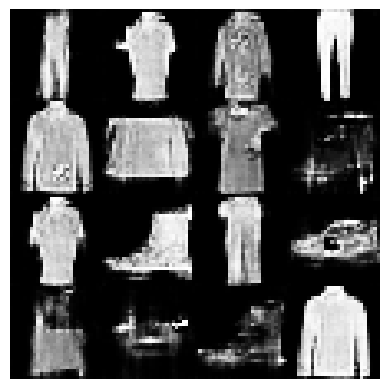

batch 0, g_loss : 0.637323, d_loss : 0.635444
batch 100, g_loss : 0.810132, d_loss : 0.633991
batch 200, g_loss : 0.716050, d_loss : 0.642954
batch 300, g_loss : 0.597492, d_loss : 0.650683

-------------------------------
Epoch is 10
1/1 [==============================] - 0s 39ms/step


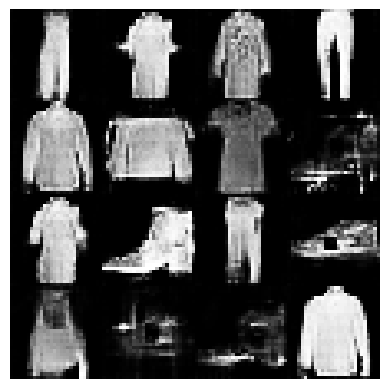

batch 0, g_loss : 1.425781, d_loss : 0.684721
batch 100, g_loss : 0.821323, d_loss : 0.653250
batch 200, g_loss : 0.297561, d_loss : 0.772670
batch 300, g_loss : 1.167861, d_loss : 0.394823

-------------------------------
Epoch is 11
1/1 [==============================] - 0s 19ms/step


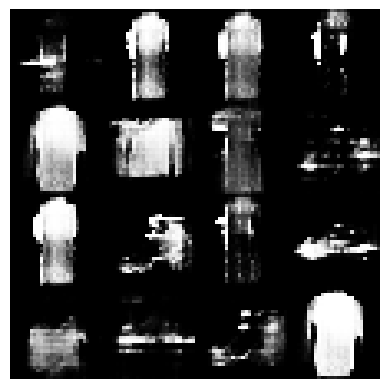

batch 0, g_loss : 1.473561, d_loss : 0.480141
batch 100, g_loss : 0.396190, d_loss : 0.185133
batch 200, g_loss : 0.991537, d_loss : 0.289265
batch 300, g_loss : 1.025010, d_loss : 0.506336

-------------------------------
Epoch is 12
1/1 [==============================] - 0s 27ms/step


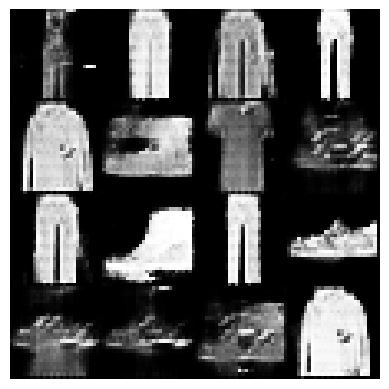

batch 0, g_loss : 0.890892, d_loss : 0.423097
batch 100, g_loss : 0.665175, d_loss : 0.379019
batch 200, g_loss : 0.358098, d_loss : 0.139268
batch 300, g_loss : 0.058083, d_loss : 0.178795

-------------------------------
Epoch is 13
1/1 [==============================] - 0s 43ms/step


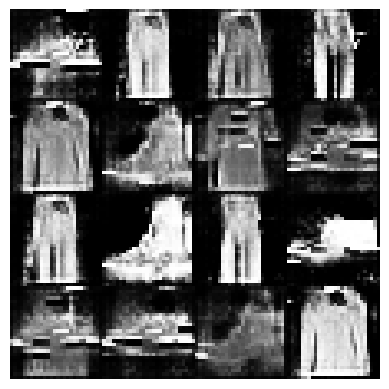

batch 0, g_loss : 0.049670, d_loss : 0.100021
batch 100, g_loss : 1.031061, d_loss : 0.322122
batch 200, g_loss : 1.089391, d_loss : 0.311080
batch 300, g_loss : 0.455328, d_loss : 0.144098

-------------------------------
Epoch is 14
1/1 [==============================] - 0s 26ms/step


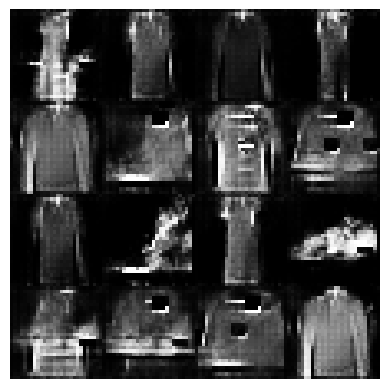

batch 0, g_loss : 1.705932, d_loss : 0.109628
batch 100, g_loss : 0.543081, d_loss : 0.540502
batch 200, g_loss : 0.321691, d_loss : 0.143773
batch 300, g_loss : 0.050668, d_loss : 0.050010

-------------------------------
Epoch is 15
1/1 [==============================] - 0s 19ms/step


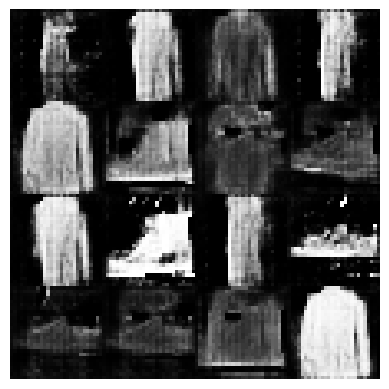

batch 0, g_loss : 0.261763, d_loss : 0.015391
batch 100, g_loss : 1.156373, d_loss : 0.357165
batch 200, g_loss : 0.980779, d_loss : 0.329284
batch 300, g_loss : 3.482867, d_loss : 0.526331

-------------------------------
Epoch is 16
1/1 [==============================] - 0s 21ms/step


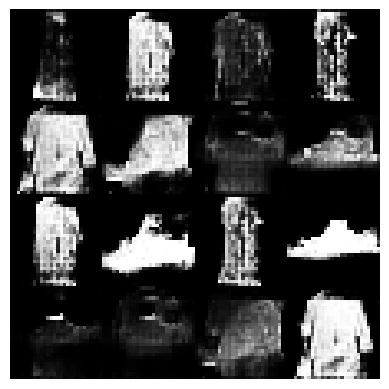

batch 0, g_loss : 1.955686, d_loss : 0.067901
batch 100, g_loss : 2.496233, d_loss : 0.731835
batch 200, g_loss : 3.920443, d_loss : -0.383426
batch 300, g_loss : 0.024913, d_loss : -0.094411

-------------------------------
Epoch is 17
1/1 [==============================] - 0s 27ms/step


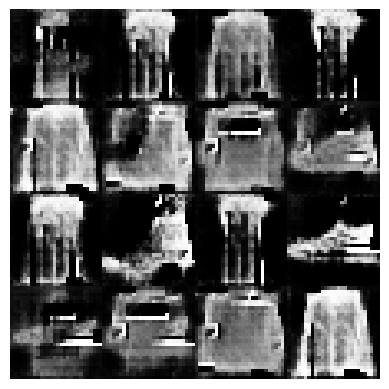

batch 0, g_loss : 0.007725, d_loss : -0.218502
batch 100, g_loss : 0.064100, d_loss : -0.150253
batch 200, g_loss : 0.134488, d_loss : 0.042919
batch 300, g_loss : 1.560691, d_loss : -0.343690

-------------------------------
Epoch is 18
1/1 [==============================] - 0s 18ms/step


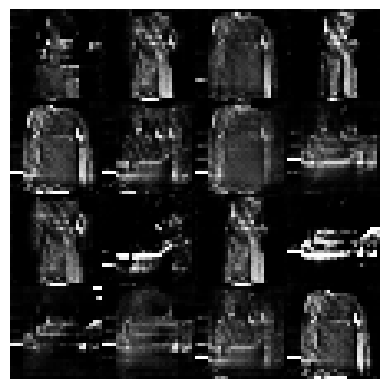

batch 0, g_loss : 3.111438, d_loss : -0.535537
batch 100, g_loss : 0.618279, d_loss : -0.017615
batch 200, g_loss : 0.453705, d_loss : -0.311086
batch 300, g_loss : 0.975251, d_loss : -0.019104

-------------------------------
Epoch is 19
1/1 [==============================] - 0s 22ms/step


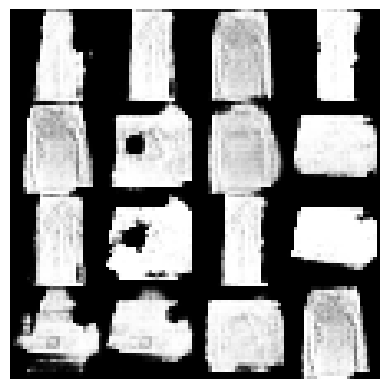

batch 0, g_loss : 2.533987, d_loss : 0.075005
batch 100, g_loss : 3.591412, d_loss : -0.558602
batch 200, g_loss : 0.027289, d_loss : -0.070819
batch 300, g_loss : 5.460801, d_loss : -0.629113

-------------------------------
Epoch is 20
1/1 [==============================] - 0s 18ms/step


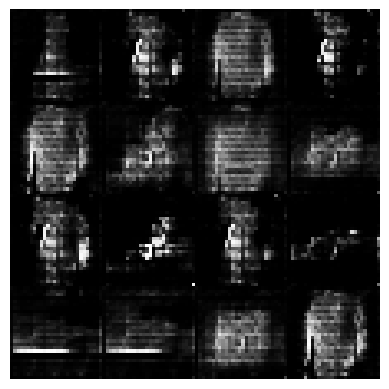

batch 0, g_loss : 1.586271, d_loss : -0.248990
batch 100, g_loss : 3.192638, d_loss : 0.120991
batch 200, g_loss : 0.001644, d_loss : -0.860369
batch 300, g_loss : 0.067316, d_loss : -0.081221

-------------------------------
Epoch is 21
1/1 [==============================] - 0s 23ms/step


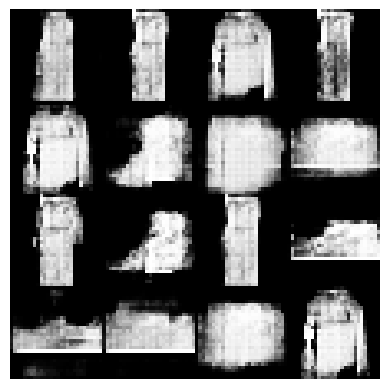

batch 0, g_loss : 0.072881, d_loss : -0.054828
batch 100, g_loss : 2.403454, d_loss : 0.050317
batch 200, g_loss : 0.850539, d_loss : 0.560548
batch 300, g_loss : 0.362068, d_loss : 0.082153

-------------------------------
Epoch is 22
1/1 [==============================] - 0s 20ms/step


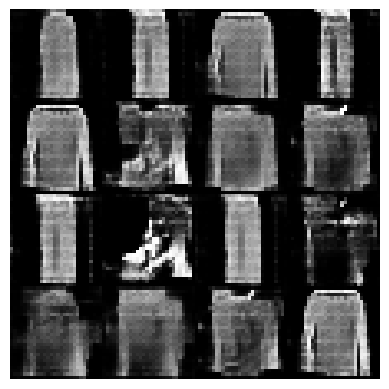

batch 0, g_loss : 2.729707, d_loss : 0.134051
batch 100, g_loss : 2.128588, d_loss : 0.142045
batch 200, g_loss : 3.734772, d_loss : 0.085489
batch 300, g_loss : 1.001551, d_loss : 0.102056

-------------------------------
Epoch is 23
1/1 [==============================] - 0s 19ms/step


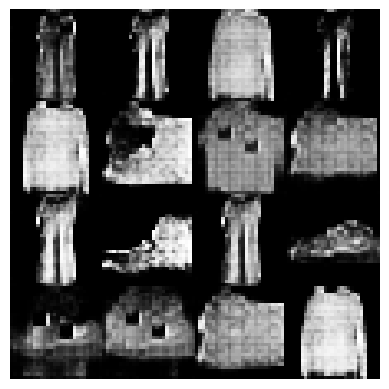

batch 0, g_loss : 1.742752, d_loss : 0.320529
batch 100, g_loss : 0.705462, d_loss : -0.024998
batch 200, g_loss : 4.263517, d_loss : -0.635140
batch 300, g_loss : 0.580235, d_loss : 0.066555

-------------------------------
Epoch is 24
1/1 [==============================] - 0s 26ms/step


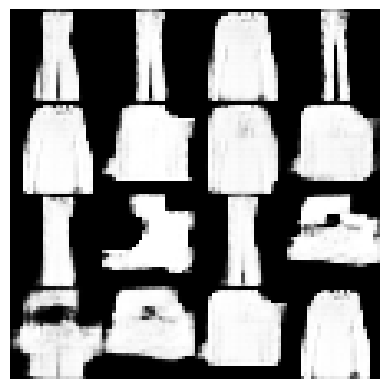

batch 0, g_loss : 3.187177, d_loss : 0.093686
batch 100, g_loss : 0.083574, d_loss : -0.080977
batch 200, g_loss : 1.702101, d_loss : 0.155842
batch 300, g_loss : 2.170999, d_loss : -0.659851

-------------------------------
Epoch is 25
1/1 [==============================] - 0s 20ms/step


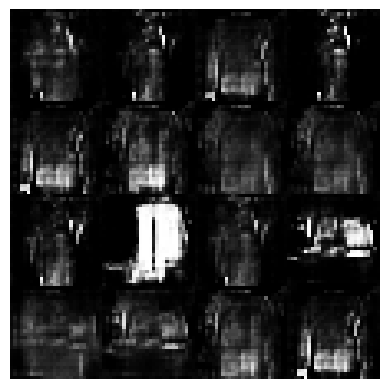

batch 0, g_loss : 3.541681, d_loss : -0.746333
batch 100, g_loss : 0.750301, d_loss : 0.042388
batch 200, g_loss : 5.663488, d_loss : -0.886214
batch 300, g_loss : 5.287851, d_loss : -0.048449

-------------------------------
Epoch is 26
1/1 [==============================] - 0s 22ms/step


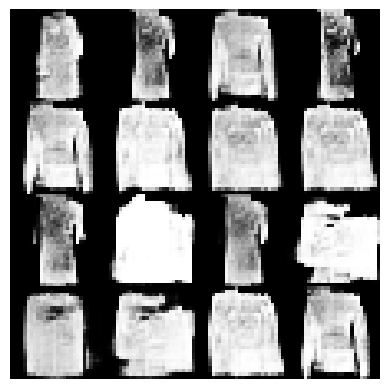

batch 0, g_loss : 2.510556, d_loss : 0.022895
batch 100, g_loss : 2.023920, d_loss : -0.865347
batch 200, g_loss : 1.260206, d_loss : -0.266112
batch 300, g_loss : 0.034872, d_loss : -0.890257

-------------------------------
Epoch is 27
1/1 [==============================] - 0s 28ms/step


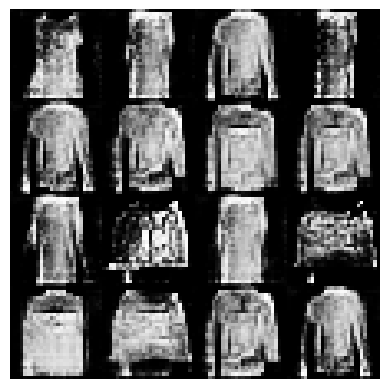

batch 0, g_loss : 0.256451, d_loss : -0.508273
batch 100, g_loss : 4.025912, d_loss : -1.384323
batch 200, g_loss : 2.776066, d_loss : -0.401774
batch 300, g_loss : 0.040360, d_loss : -0.065177

-------------------------------
Epoch is 28
1/1 [==============================] - 0s 19ms/step


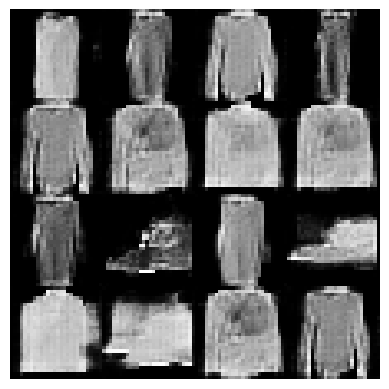

batch 0, g_loss : 0.043254, d_loss : -0.154158
batch 100, g_loss : 4.835490, d_loss : -1.552693
batch 200, g_loss : 0.485689, d_loss : -0.033295
batch 300, g_loss : 6.811490, d_loss : -0.624612

-------------------------------
Epoch is 29
1/1 [==============================] - 0s 19ms/step


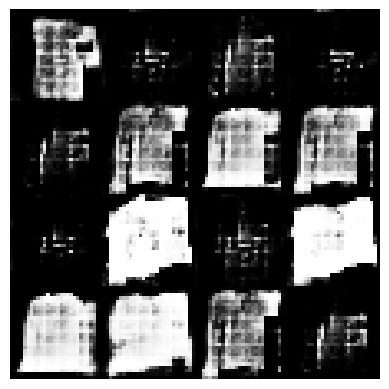

batch 0, g_loss : 1.159674, d_loss : -1.074212
batch 100, g_loss : 1.791447, d_loss : 0.104286
batch 200, g_loss : 1.938844, d_loss : -0.240950
batch 300, g_loss : 0.002597, d_loss : -2.034469

-------------------------------
Epoch is 30
1/1 [==============================] - 0s 43ms/step


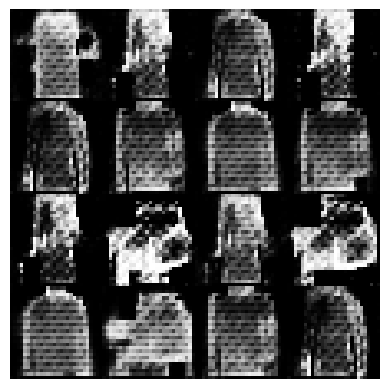

batch 0, g_loss : 0.004718, d_loss : -1.769666


In [ ]:
batch = 225
epochs = 50
g_model, d_model, _ = train_gan(X_train, y_train, batch, epochs, models)

In [ ]:
show_gif('imgs', 'GAN.gif')

# **7. Evaluasi Model**

In [ ]:
seed = tf.random.normal(shape=(4, 128))
images = g_model.predict(seed)

for i in range(4):
    plt.subplot(2,2,1+i)
    plt.imshow(np.reshape(images[i], (28,28,)),cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

In [ ]:
images = generate_images(g_model, 25)
plt.figure(figsize = (6,6))
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

In [1]:
images = generate_best_images(g_model, d_model, 25)
plt.figure(figsize = (6,6))
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

NameError: ignored